In [179]:
import numpy as np
import pandas as pd
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### Problem 1

In [149]:
df=pd.read_csv("data/incomes.txt",names=['Income'])
df.head()

,Income
0,53711.544399
1,99731.233349
2,84773.605417
3,75184.025931
4,73390.955933


##### a

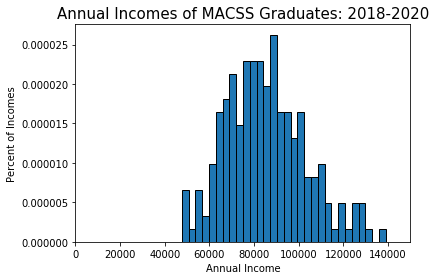

In [150]:
num_bins = 30
plt.hist(df['Income'], num_bins, normed=True, edgecolor='k')
plt.title('Annual Incomes of MACSS Graduates: 2018-2020', fontsize=15)
plt.xlabel('Annual Income')
plt.ylabel('Percent of Incomes')
plt.xlim([1, 150000])
plt.show()

##### b

In [151]:
# Define function that generates values of a lognormal pdf
def trunc_lognorm_pdf(xvals, mu, sigma, cut_lb, cut_ub):

    if cut_ub == 'None' and cut_lb == 'None':
        prob_notcut = 1.0
    elif cut_ub == 'None' and cut_lb != 'None':
        prob_notcut = 1.0 - sts.lognorm.cdf(cut_lb, sigma, scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb == 'None':
        prob_notcut = sts.lognorm.cdf(cut_ub, sigma,scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb != 'None':
        prob_notcut = (sts.lognorm.cdf(cut_ub, sigma,scale=np.exp(mu)) -
                       sts.lognorm.cdf(cut_lb, sigma,scale=np.exp(mu)))
            
    pdf_vals    = ((1/(xvals*sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))) /
                    prob_notcut)
    
    return pdf_vals

In [152]:
#This function computes the two data moments for GMM (mean(data), S.D.(data)).
def data_moments(xvals):

    mean_data = xvals.mean()
    std_data = xvals.std()
    
    return mean_data, std_data

In [153]:
#This function computes the two model moments for GMM (mean(model data), S.D.(model data)).
def model_moments(mu, sigma, cut_lb, cut_ub):
   
    xfx = lambda x: x * trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (mean_model, m_m_err) = intgr.quad(xfx, cut_lb, cut_ub)
    x2fx = lambda x: ((x - mean_model) ** 2) * trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub) 
    (var_model, v_m_err) = intgr.quad(x2fx, cut_lb, cut_ub)
    
    return mean_model, np.sqrt(var_model)

In [154]:
#This function computes the vector of moment errors for GMM.
def err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple):

    mean_data, std_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[mean_model], [std_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

In [155]:
def criterion(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.    
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

In [156]:
#Use identity matrix
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2) #Identity matrix
gmm_args = (df['Income'], 0.0, 150000.0, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-14,
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)

mean_data, std_data = data_moments(df['Income'])
mean_model, std_model = model_moments(mu_GMM1, sig_GMM1, 0.0, 150000.0)
err1 = err_vec(df['Income'], mu_GMM1, sig_GMM1, 0.0, 150000.0, False).reshape(2,)
print('Mean of points =', mean_data, ', Standard Deviation of points =', std_data)
print('Mean of model =', mean_model, ', Standard Deviation =', std_model)
print('Error vector=', err1)
print('GMM criterion function:',results.fun)

mu_GMM1= 11.33353348254704  sig_GMM1= 0.21386191435240418
Mean of points = 85276.82360625808 , Standard Deviation of points = 18037.692869371564
Mean of model = 85276.82405894266 , Standard Deviation = 18037.692424757075
Error vector= [ 5.30841270e-09 -2.46491883e-08]
GMM criterion function: [[6.35761731e-16]]


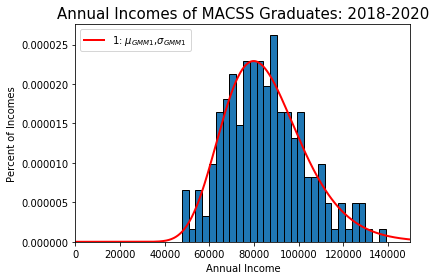

In [157]:
# Plot the histogram of the data
num_bins = 30
plt.hist(df['Income'], num_bins, normed=True, edgecolor='k')
plt.title('Annual Incomes of MACSS Graduates: 2018-2020', fontsize=15)
plt.xlabel('Annual Income')
plt.ylabel('Percent of Incomes')
plt.xlim([1, 150000])

# Plot the estimated GMM PDF
dist_pts = np.linspace(0, 150000, 1000)
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1, 0.0, 150000),
         linewidth=2, color='r', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper left')
plt.show()

##### c

In [158]:
def get_Err_mat2(pts, mu, sigma, cut_lb, cut_ub, simple=False):
    '''
    --------------------------------------------------------------------
    This function computes the R x N matrix of errors from each
    observation for each moment. In this function, we have hard coded R = 2.
    --------------------------------------------------------------------
    '''
    R = 2
    N = len(pts)
    Err_mat = np.zeros((R, N))
    mean_model, std_model = model_moments(mu, sigma, cut_lb, cut_ub)
    if simple:
        Err_mat[0, :] = pts - mean_model
        Err_mat[1, :] = ((mean_data - pts) ** 2) - std_model
    else:
        Err_mat[0, :] = (pts - mean_model) / mean_model
        Err_mat[1, :] = (((mean_data - pts) ** 2) - std_model) / std_model
    
    return Err_mat

In [159]:
Err_mat =get_Err_mat2(df['Income'], mu_GMM1, sig_GMM1, 0.0, 150000.0, False)
VCV2 = (1 / df['Income'].shape[0]) * (Err_mat @ Err_mat.T)
print("VCV2:","\n",VCV2)
W_hat2 = lin.inv(VCV2)
print("W_hat2:","\n",W_hat2)

VCV2: 
 [[4.45167060e-02 1.67963797e+03]
 [1.67963797e+03 9.49413425e+08]]
W_hat2: 
 [[ 2.40701669e+01 -4.25833101e-05]
 [-4.25833101e-05  1.12861743e-09]]


In [160]:
#Use Two moments, two-step optimal weighting matrix
gmm_args = (df['Income'], 0.0, 150000.0, W_hat2)
params_init = np.array([mu_GMM1, sig_GMM1])
results2 = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-14,
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results2.x
print('mu_GMM2=', mu_GMM2, ' sig_GMM2=', sig_GMM2)

mean_model2, std_model2 = model_moments(mu_GMM2, sig_GMM2, 0.0, 150000.0)
err2 = err_vec(df['Income'], mu_GMM2, sig_GMM2, 0.0, 150000.0, False).reshape(2,)
print('Mean of points =', mean_data, ', Standard Deviation of points =', std_data)
print('Mean of model =', mean_model2, ', Standard Deviation of model =', std_model2)
print('Error vector=', err2)
print('GMM criterion function:',results2.fun)

mu_GMM2= 11.333533472755567  sig_GMM2= 0.2138619137414828
Mean of points = 85276.82360625808 , Standard Deviation of points = 18037.692869371564
Mean of model = 85276.82324668273 , Standard Deviation of model = 18037.6922484816
Error vector= [-4.21656596e-09 -3.44218060e-08]
GMM criterion function: [[4.27941452e-16]]


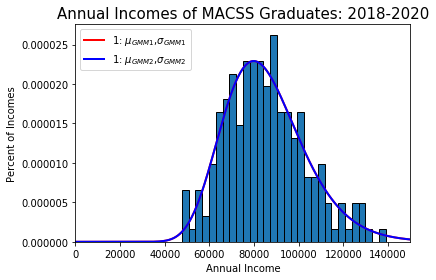

In [161]:
# Plot the histogram of the data
num_bins = 30
plt.hist(df['Income'], num_bins, normed=True, edgecolor='k')
plt.title('Annual Incomes of MACSS Graduates: 2018-2020', fontsize=15)
plt.xlabel('Annual Income')
plt.ylabel('Percent of Incomes')
plt.xlim([1, 150000])

# Plot the estimated GMM PDF with identity matrix
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1, 0.0, 150000),
         linewidth=2, color='r', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper left')

# Plot the estimated GMM PDF with weighting matrix
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM2, sig_GMM2, 0.0, 150000),
         linewidth=2, color='b', label='1: $\mu_{GMM2}$,$\sigma_{GMM2}$')
plt.legend(loc='upper left')
plt.show()

##### d

In [162]:
def data_moments3(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the three data moments for GMM
    (binpct_1, binpct_2, binpct_3).
    --------------------------------------------------------------------
    '''
    bpct_1_dat = xvals[xvals <75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >=75000) & (xvals < 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = xvals[xvals >= 100000].shape[0] / xvals.shape[0]

    return bpct_1_dat, bpct_2_dat, bpct_3_dat

In [163]:
def model_moments3(mu, sigma, cut_lb, cut_ub):
    '''
    --------------------------------------------------------------------
    This function computes the three model moments for GMM
    (binpct_1, binpct_2, binpct_3, binpct_4).
    --------------------------------------------------------------------
    '''
    xfx = lambda x: trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 0.0, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 100000, 150000)
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod

In [164]:
def err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    '''
    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

In [165]:
def criterion3(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------   
    '''
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err 
    
    return crit_val

In [166]:
#Estimate the lognormal PDF to fit the data by GMM using different moments
W_hat1_3 = np.eye(3)
gmm_args = (df['Income'], 0.0, 150000.0, W_hat1_3)

results_3 = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))

mu_GMM1_3, sig_GMM1_3 = results_3.x
print('mu_GMM1_3=', mu_GMM1_3, ' sig_GMM1_3=', sig_GMM1_3)
err3 = err_vec3(df['Income'], mu_GMM1_3, sig_GMM1_3, 0.0, 150000.0, False).reshape(3,)

bpct_1_dat, bpct_2_dat, bpct_3_dat=data_moments3(df['Income'])
pert1, pert2, pert3 = model_moments3(mu_GMM1_3, sig_GMM1_3, 0.0, 150000.0)

print('Error vector=', err3)
print('GMM criterion function:',results_3.fun)
mm=pd.DataFrame({'Data Moments':[bpct_1_dat, bpct_2_dat, bpct_3_dat],
                'Model Momets':[pert1, pert2, pert3]},
                index=['Percent <75000','Percent 75000~100000','Percent >=100000'])
mm

mu_GMM1_3= 11.3367051627647  sig_GMM1_3= 0.21151353494382988
Error vector= [ 1.61522382e-07 -7.19526214e-08 -6.24020183e-08]
GMM criterion function: [[3.51606715e-14]]


,Data Moments,Model Momets
Percent <75000,0.3,0.3
Percent 75000~100000,0.5,0.5
Percent >=100000,0.2,0.2


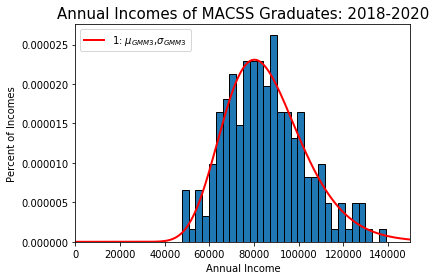

In [167]:
# Plot the histogram of the data
num_bins = 30
plt.hist(df['Income'], num_bins, normed=True, edgecolor='k')
plt.title('Annual Incomes of MACSS Graduates: 2018-2020', fontsize=15)
plt.xlabel('Annual Income')
plt.ylabel('Percent of Incomes')
plt.xlim([1, 150000])

# Plot the estimated GMM PDF using three moments with identity matrix
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1_3, sig_GMM1_3, 0.0, 150000),
         linewidth=2, color='r', label='1: $\mu_{GMM3}$,$\sigma_{GMM3}$')
plt.legend(loc='upper left')

plt.show()

##### e

In [168]:
def get_Err_mat3(pts, mu, sigma, cut_lb, cut_ub, simple=False):
    '''
    --------------------------------------------------------------------
    This function computes the R x N matrix of errors from each
    observation for each moment. In this function, we have hard coded R = 3.
    --------------------------------------------------------------------
    '''
    R = 3
    N = len(pts)
    Err_mat = np.zeros((R, N))
    pct_1_mod, pct_2_mod, pct_3_mod = \
        model_moments3(mu, sigma, cut_lb, cut_ub)
    if simple:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = pts_in_grp1 - pct_1_mod
        pts_in_grp2 = (pts >= 75000) & (pts < 100000)
        Err_mat[1, :] = pts_in_grp2 - pct_2_mod
        pts_in_grp3 = pts >= 100000
        Err_mat[2, :] = pts_in_grp3 - pct_3_mod

    else:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = (pts_in_grp1 - pct_1_mod) / pct_1_mod
        pts_in_grp2 = (pts >= 75000) & (pts < 100000)
        Err_mat[1, :] = (pts_in_grp2 - pct_2_mod) / pct_2_mod
        pts_in_grp3 = pts >= 100000
        Err_mat[2, :] = (pts_in_grp3 - pct_3_mod) / pct_3_mod
    
    return Err_mat

In [169]:
Err_mat3w = get_Err_mat3(df['Income'], mu_GMM1_3, sig_GMM1_3, 0.0, 150000.0, False)
VCV2_3w = (1 / df['Income'].shape[0]) * (Err_mat3w @ Err_mat3w.T)
print("VCV2_3:","\n",VCV2_3w)
# We use the pseudo-inverse command here because the VCV matrix is poorly conditioned
W_hat2_3 = lin.pinv(VCV2_3w)
print("W_hat2_3","\n",W_hat2_3)

VCV2_3: 
 [[ 2.33333258 -0.99999991 -0.9999999 ]
 [-0.99999991  1.00000014 -1.00000013]
 [-0.9999999  -1.00000013  4.0000005 ]]
W_hat2_3 
 [[ 0.25761775 -0.14958453 -0.01246539]
 [-0.14958453  0.11911361 -0.07340718]
 [-0.01246539 -0.07340718  0.20221604]]


In [170]:
gmm_args = (df['Income'], 0.0, 150000.0, W_hat2_3)
results_4 = opt.minimize(criterion3, params_init, args=(gmm_args),method='L-BFGS-B')
mu_GMM1_3w, sig_GMM1_3w = results_4.x
print('mu_GMM1_3w=', mu_GMM1_3w, ' sig_GMM1_3w=', sig_GMM1_3w)
err3w = err_vec3(df['Income'], mu_GMM1_3w, sig_GMM1_3w, 0.0, 150000.0, False).reshape(3,)

pert1, pert2, pert3 = model_moments3(mu_GMM1_3w, sig_GMM1_3w, 0.0, 150000.0)

print('Error vector=', err3w)
print('GMM criterion function:',results_4.fun)
mm=pd.DataFrame({'Data Moments':[bpct_1_dat, bpct_2_dat, bpct_3_dat],
                'Model Momets':[pert1, pert2, pert3]},
                index=['Percent <75000','Percent 75000~100000','Percent >=100000'])
mm

mu_GMM1_3w= 11.33353348254704  sig_GMM1_3w= 0.21386191435240418
Error vector= [ 0.02420924 -0.01108994 -0.00858902]
GMM criterion function: [[0.00025207]]


,Data Moments,Model Momets
Percent <75000,0.3,0.307263
Percent 75000~100000,0.5,0.494455
Percent >=100000,0.2,0.198282


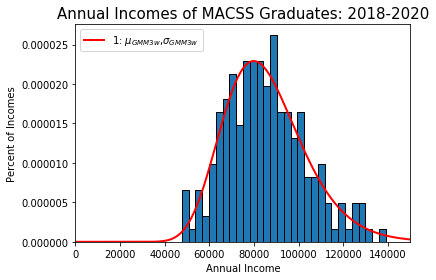

In [171]:
# Plot the histogram of the data
num_bins = 30
plt.hist(df['Income'], num_bins, normed=True, edgecolor='k')
plt.title('Annual Incomes of MACSS Graduates: 2018-2020', fontsize=15)
plt.xlabel('Annual Income')
plt.ylabel('Percent of Incomes')
plt.xlim([1, 150000])

# Plot the estimated GMM PDF using three moments with identity matrix
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1_3w, sig_GMM1_3w, 0.0, 150000),
         linewidth=2, color='r', label='1: $\mu_{GMM3w}$,$\sigma_{GMM3w}$')
plt.legend(loc='upper left')

plt.show()

##### f

In [180]:
mu=[mu_GMM1,mu_GMM2,mu_GMM1_3,mu_GMM1_3w]
sig=[sig_GMM1,sig_GMM2,sig_GMM1_3,sig_GMM1_3w]
GMMV=[results.fun,results2.fun,results_3.fun,results_4.fun]

In [183]:
pd.DataFrame({"mu":mu,"sigma":sig,"GMM Fn Value":GMMV}
            ,index=['2 moments+Identity Matrix','2 moments+Weighted Matrix',
                   '3 moments+Identity Matrix','3 moments+Weighted Matrix']).astype(float)

,mu,sigma,GMM Fn Value
2 moments+Identity Matrix,11.333533,0.213862,1.821290e-03
2 moments+Weighted Matrix,11.333533,0.213862,4.279415e-16
3 moments+Identity Matrix,11.336705,0.211514,3.516067e-14
3 moments+Weighted Matrix,11.333533,0.213862,2.520739e-04


The best fitting model is from (c) as it has the lowest minimized GMM function value. 

This model uses the average and standard deviation of income as two moments with two-step optimal weighting matrix.

## Problem 2

In [174]:
df=pd.read_csv("data/sick.txt").astype('float64')
df.head()

,sick,age,children,avgtemp_winter
0,1.67,57.47,3.04,54.10
1,0.71,26.77,1.20,36.54
2,1.39,41.85,2.31,32.38
3,1.37,51.27,2.46,52.94
4,1.45,44.22,2.72,45.90


In [175]:
# Simple Moment errors.
def err_vec(df,b0,b1,b2,b3):
    
    #Model Moments
    yhat=b0+b1*df['age']+b2*df['children']+b3*df['avgtemp_winter']
    
    #Data Moments
    y=df['sick']
    
    err_vec = yhat - y
    
    return err_vec

In [176]:
def criterion(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM sum of squared moment errors
    criterion function value given parameter values and a weighting matrix.    
    --------------------------------------------------------------------
    '''
    
    b0,b1,b2,b3 = params
    df, W = args
    err = err_vec(df,b0,b1,b2,b3)
    crit_val = err.T @ W @ err
    
    return crit_val

In [177]:
b0, b1, b2, b3 = 1, 0, 0, 0
params_init = np.array([b0, b1, b2, b3])
W_hat = np.eye(df.shape[0])
gmm_args = (df, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-14,method='L-BFGS-B')
b0, b1, b2, b3 = results.x

In [178]:
print("Estimate of b0",b0)
print("Estimate of b1",b1)
print("Estimate of b2",b2)
print("Estimate of b3",b3)
print('GMM criterion function:',results.fun)

Estimate of b0 0.2516448636612042
Estimate of b1 0.012933470965564249
Estimate of b2 0.40050098470289774
Estimate of b3 -0.009991709711286762
GMM criterion function: 0.0018212898060782808
